In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CalendarSpreadArb').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 05:08:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pyspark.pandas as ps
from pyspark.pandas.config import set_option
set_option("compute.ops_on_diff_frames", True)
from functools import reduce

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from xgboost import XGBRegressor,XGBClassifier, plot_importance
from functools import reduce
warnings.filterwarnings('ignore')

In [4]:
path = r"raw data.xlsx"

In [5]:
index_close = pd.read_excel(path, sheet_name = 'index close', index_col = 0, header = 3)
index_turnover = pd.read_excel(path, sheet_name = 'index turnover', index_col = 0, header = 3)
index_volume = pd.read_excel(path, sheet_name = 'index volume', index_col = 0, header = 3)
ic_close = pd.read_excel(path, sheet_name = 'futures close', index_col = 0, header = 3)
ic_volume = pd.read_excel(path, sheet_name = 'futures volume', index_col = 0, header = 3)
ic_oi = pd.read_excel(path, sheet_name = 'futures oi', index_col = 0, header = 3)
broker_oi = pd.read_excel(path, sheet_name = 'broker oi', index_col = 0, header = 0)
public_enhance  = pd.read_excel(path, sheet_name = 'public enhance', index_col = 0, header = 3)
public_alpha = pd.read_excel(path, sheet_name = 'public alpha', index_col = 0, header = 3)
private_enhance = pd.read_excel(path, sheet_name = 'private enhance', index_col = 0, header = 0)
private_alpha = pd.read_excel(path, sheet_name = 'private alpha', index_col = 0, header = 0)
contract_spec = pd.read_excel(path, sheet_name = 'contract spec', index_col = 0, header = 1)

In [6]:
contract = contract_spec.iloc[:,:4]
expiry = contract_spec.loc[:,contract_spec.columns.str.contains('CFE.1')]
daystoexpire = contract_spec.loc[:,contract_spec.columns.str.contains('CFE.2')]
dividend = contract_spec.loc[:,contract_spec.columns.str.contains('CFE.3')]


columnname = ['IC00','IC01','IC02','IC03']

ic_close.columns = columnname
ic_volume.columns = columnname
ic_oi.columns = columnname
contract.columns = columnname
expiry.columns = columnname
daystoexpire.columns = columnname
dividend.columns = columnname

,public enhance,public alpha
count,1998.000000,1998.000000
mean,1.232349,1.168399
std,0.332047,0.096192
min,0.737632,0.995199
25%,0.979392,1.070845
50%,1.068037,1.122111
75%,1.586312,1.275966
max,1.990226,1.328812


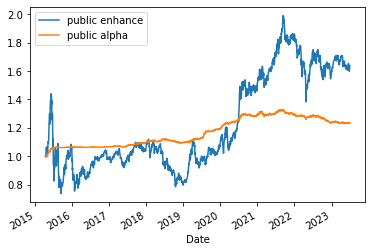

In [7]:
# private fund-related data are on weekly basis, we have to make it consistent with all other daily frequecy data

private_enhance.index = pd.to_datetime(private_enhance.index)
private_alpha.index = pd.to_datetime(private_alpha.index)

df = [public_enhance.reset_index(),public_alpha.reset_index()]
public_fund_value = reduce(lambda left,right: pd.merge(left,right, on='Date', how='outer'),df).set_index('Date')
public_fund_value.plot()
public_fund_value.describe()


,private enhance,private alpha
count,417.000000,420.000000
mean,2.097431,1.633523
std,0.925672,0.416107
min,1.000000,1.000000
25%,1.330000,1.226025
50%,1.767900,1.577050
75%,2.988700,2.048200
max,3.708100,2.318700


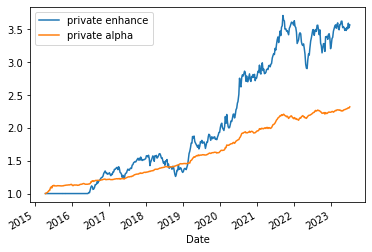

In [8]:
df = [private_enhance.reset_index(),private_alpha.reset_index()]
private_fund_value = reduce(lambda left,right: pd.merge(left,right, on='Date', how='outer'),df).set_index('Date')
private_fund_value.plot()
private_fund_value.describe()

In [9]:
df = [public_enhance.reset_index(),public_alpha.reset_index(),private_enhance.reset_index(),private_alpha.reset_index()]
fund_value = reduce(lambda left,right: pd.merge(left,right, on='Date', how='outer'),df).set_index('Date')

In [10]:
fund_value.isnull().sum().sort_values(ascending = False)

private enhance    1581
private alpha      1578
public enhance        0
public alpha          0
dtype: int64

In [11]:
fund_value = fund_value.fillna(method = 'ffill')
fund_value = fund_value.fillna(method = 'bfill')

In [12]:
fund_value.isnull().sum().sort_values(ascending = False)

public enhance     0
public alpha       0
private enhance    0
private alpha      0
dtype: int64

<AxesSubplot:xlabel='Date'>

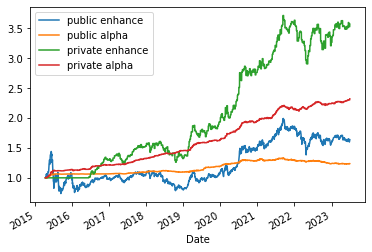

In [13]:
fund_value.plot()

<AxesSubplot:xlabel='Date'>

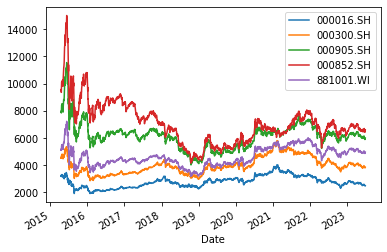

In [14]:
index_close.plot()

In [15]:
index_close.describe()

,000016.SH,000300.SH,000905.SH,000852.SH,881001.WI
count,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000
mean,2770.637948,3986.236540,6159.950597,7077.221180,4635.589830
std,415.402838,621.873271,962.611833,1543.415572,678.298142
min,1912.720500,2853.756200,4018.461400,4149.444200,3179.535300
25%,2446.437475,3480.064900,5685.512200,6169.545500,4156.730175
50%,2743.013950,3891.974150,6223.043150,6893.965250,4501.630600
75%,3018.022200,4265.003525,6511.977975,7839.412175,5175.707050
max,4028.528900,5807.719100,11545.890600,15006.338800,7224.264400


<AxesSubplot:>

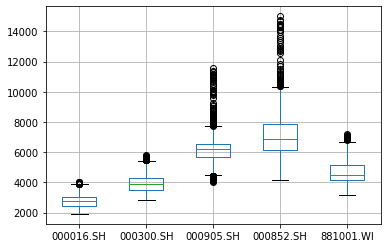

In [16]:
index_close.boxplot()

<AxesSubplot:xlabel='Date'>

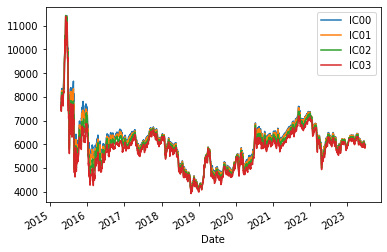

In [17]:
ic_close.plot()

In [18]:
ic_close.describe()

,IC00,IC01,IC02,IC03
count,1998.000000,1998.000000,1998.000000,1998.000000
mean,6114.192392,6050.138138,5939.276877,5804.541642
std,945.965093,932.615769,923.309327,907.493349
min,4033.200000,3978.000000,3963.800000,3918.000000
25%,5628.850000,5527.400000,5350.750000,5203.850000
50%,6193.700000,6137.100000,6044.100000,5907.100000
75%,6471.300000,6405.750000,6311.400000,6176.950000
max,11427.800000,11400.000000,11430.000000,11387.600000


<AxesSubplot:ylabel='Density'>

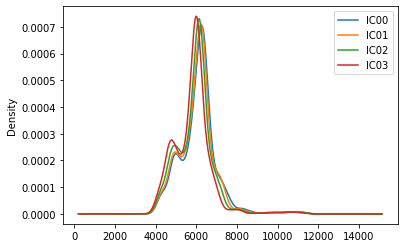

In [19]:
ic_close.plot(kind='kde')

,volume
count,1.998000e+03
mean,1.154353e+10
std,4.916041e+09
min,2.842674e+09
25%,7.351183e+09
50%,1.079123e+10
75%,1.473998e+10
max,3.258654e+10


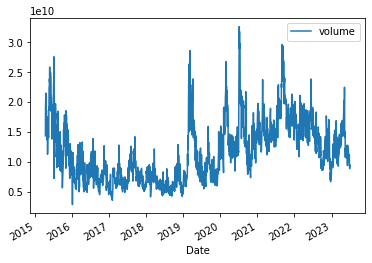

In [20]:
#explore index volume
index_volume.plot()
index_volume.describe()

,IC00,IC01,IC02,IC03
count,1998.000000,1998.000000,1998.00000,1998.000000
mean,47490.538539,12046.420921,8580.60961,3581.294294
std,49646.116999,20848.555143,8560.71588,3947.520990
min,2184.000000,68.000000,73.00000,13.000000
25%,11596.500000,1390.750000,881.00000,273.000000
50%,40342.500000,4067.000000,7199.00000,2143.500000
75%,66945.500000,14897.750000,13879.75000,6189.000000
max,502523.000000,385745.000000,53353.00000,24425.000000


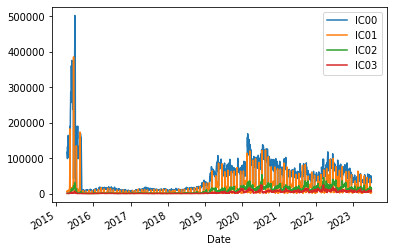

In [21]:
ic_volume.plot()
ic_volume.describe()

<AxesSubplot:>

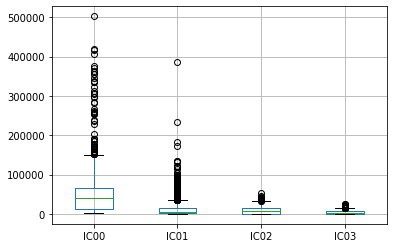

In [22]:
ic_volume.boxplot()

,IC00,IC01,IC02,IC03
count,1998.000000,1998.000000,1998.000000,1998.000000
mean,52468.825826,27235.350350,42457.540541,20133.288288
std,41569.856015,38343.363867,41200.000053,25523.153423
min,0.000000,67.000000,215.000000,15.000000
25%,18578.750000,2804.250000,5970.000000,1878.750000
50%,35235.500000,9199.500000,26412.000000,5677.000000
75%,85556.500000,32460.250000,78133.750000,33529.500000
max,180863.000000,179287.000000,149517.000000,103008.000000


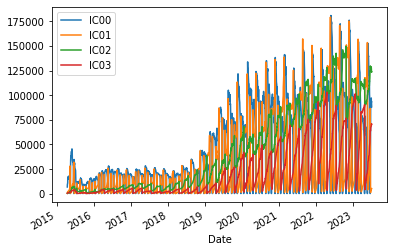

In [23]:
ic_oi.plot()
ic_oi.describe()

<AxesSubplot:>

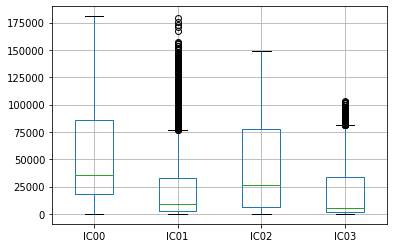

In [24]:
ic_oi.boxplot()

<AxesSubplot:xlabel='Date'>

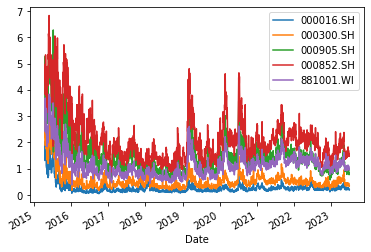

In [25]:
index_turnover.plot()

<AxesSubplot:>

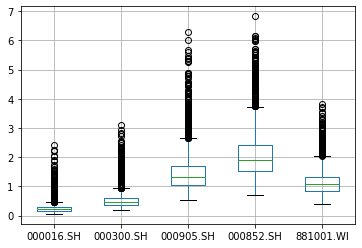

In [26]:
index_turnover.boxplot()


<AxesSubplot:xlabel='Date'>

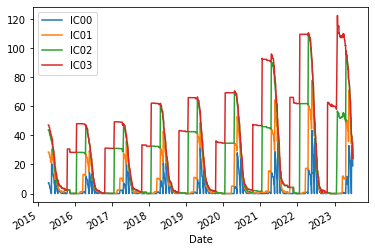

In [27]:
dividend.plot()

In [28]:
##Y

futures = 'IC'
k = 5
Y = pd.DataFrame()
for near,far in [['00','01'],['00','02'],['00','03'],['01','02'],['01','03'],['02','03']]:
    spread = ic_close[futures+far] - ic_close[futures+near]   # ic_close['IC01'] - ic_close['IC00']
    Y['_'.join((near,far))] = (spread.diff(k).shift(-k) / (ic_close[futures+far] + ic_close[futures+near])) / k * 250


In [29]:
Y

,00_01,00_02,00_03,01_02,01_03,02_03
Date,,,,,,
2015-04-16,-0.020182,-0.322455,-0.456532,-0.303355,-0.437896,-0.134264
2015-04-17,-0.012311,-0.188065,-0.300257,-0.176660,-0.289431,-0.112717
2015-04-20,0.107753,0.141607,-0.149896,0.033502,-0.260522,-0.295794
2015-04-21,-0.085104,-0.115068,-0.168509,-0.029816,-0.083038,-0.053239
2015-04-22,-0.091932,-0.072139,-0.047156,0.020426,0.046096,0.025696
...,...,...,...,...,...,...
2023-06-26,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-27,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-28,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

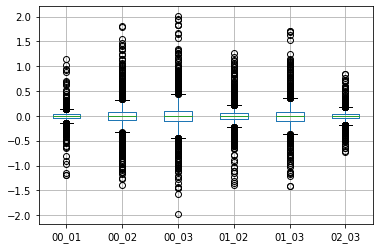

In [30]:
Y.boxplot()

(-1.0, 1.0)

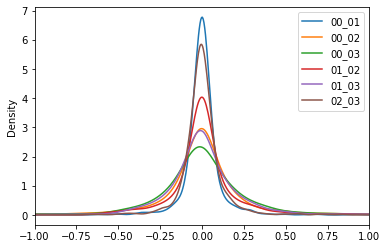

In [31]:
Y.plot(kind='kde')
plt.xlim((-1,1))

In [32]:
Y.describe()

,00_01,00_02,00_03,01_02,01_03,02_03
count,1993.000000,1.993000e+03,1993.000000,1993.000000,1993.000000,1993.000000
mean,0.001288,3.249217e-03,0.003789,0.001931,0.002388,0.000319
std,0.125920,2.713231e-01,0.308939,0.214333,0.247940,0.119683
min,-1.181149,-1.388889e+00,-1.974398,-1.382373,-1.420582,-0.717217
25%,-0.034048,-8.372935e-02,-0.112379,-0.055278,-0.096187,-0.045656
50%,0.001560,3.672233e-15,-0.008993,0.000000,-0.006486,-0.002534
75%,0.034445,8.196465e-02,0.108271,0.054650,0.087021,0.041718
max,1.153276,1.803146e+00,2.003870,1.259570,1.704400,0.840411


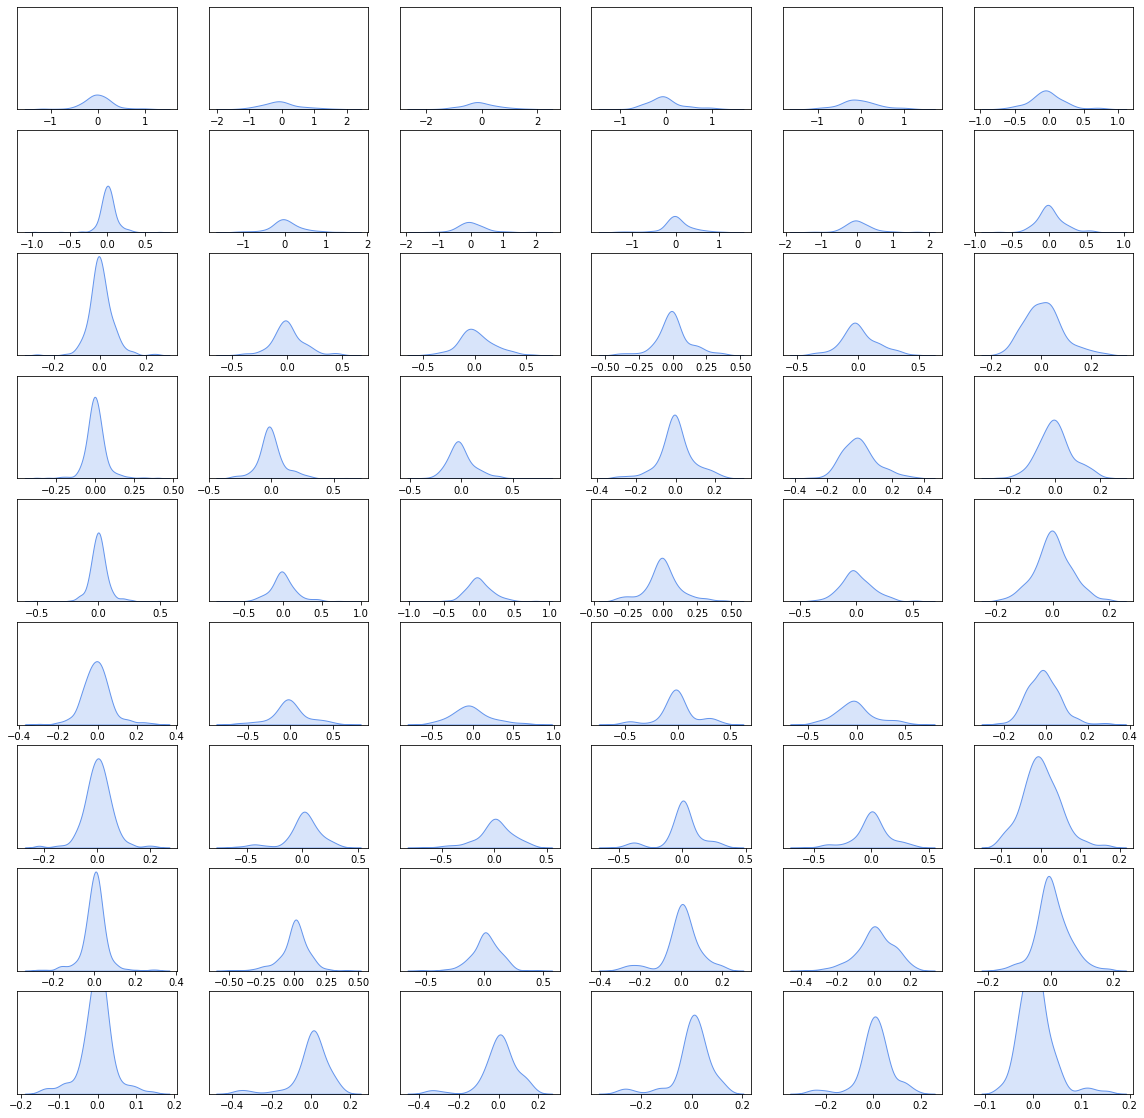

In [33]:
fig = plt.figure(figsize = (20,20))
count=1
for i,year in enumerate(Y.index.year.unique().tolist()):
    for j,item in enumerate(Y.columns):
        plt.subplot(9,6,count)
        temp = Y[Y.index.year == year][item]
        sns.kdeplot(temp, shade = True, color = 'cornflowerblue')
        plt.ylim(0,10)
        plt.ylabel('')
        plt.xlabel('')
        plt.yticks([])
        count += 1


In [34]:
## X
X1 = pd.DataFrame(index = Y.index)

#	X1:Derived Factors Related to Risk-Return Characteristic
X1['CSI500_CLOSE'] = index_close['000905.SH']
X1['WINDA_CLOSE'] = index_close['881001.WI']

for k in [1,5,10,20,60]:
    X1.loc[:,'_'.join(('CSI500_RET',str(k)))] = index_close['000905.SH'].pct_change(k)
    X1.loc[:,'_'.join(('WINDA_RET',str(k)))] = index_close['881001.WI'].pct_change(k)
    X1.loc[:,'_'.join(('CSI500_VOL',str(k)))] = index_close['000905.SH'].pct_change().rolling(k).std()
    X1.loc[:,'_'.join(('CSI500_TURNOVER',str(k)))] = index_turnover['000905.SH'].rolling(k).mean()
    X1.loc[:,'_'.join(('WINDA_TURNOVER',str(k)))] = index_turnover['881001.WI'].rolling(k).mean()
    X1.loc[:,'_'.join(('STYLE_1000_300_RET',str(k)))] = index_close['000852.SH'].pct_change(k) - index_close['000300.SH'].pct_change(k)
    X1.loc[:,'_'.join(('STYLE_1000_50_RET',str(k)))] = index_close['000852.SH'].pct_change(k) - index_close['000016.SH'].pct_change(k)
    X1.loc[:,'_'.join(('STYLE_1000_500_RET',str(k)))] = index_close['000852.SH'].pct_change(k) - index_close['000905.SH'].pct_change(k)
    X1.loc[:,'_'.join(('STYLE_500_300_RET',str(k)))] = index_close['000905.SH'].pct_change(k) - index_close['000300.SH'].pct_change(k)
    X1.loc[:,'_'.join(('STYLE_500_50_RET',str(k)))] = index_close['000905.SH'].pct_change(k) - index_close['000016.SH'].pct_change(k)
    X1.loc[:,'_'.join(('STYLE_300_50_RET',str(k)))] = index_close['000300.SH'].pct_change(k) - index_close['000016.SH'].pct_change(k)
    
    X1.loc[:,'_'.join(('STYLE_1000_300_RET',str(k),'STD'))] = X1.loc[:,'_'.join(('STYLE_1000_300_RET',str(k)))].rolling(60).std()
    X1.loc[:,'_'.join(('STYLE_1000_50_RET',str(k),'STD'))] = X1.loc[:,'_'.join(('STYLE_1000_50_RET',str(k)))].rolling(60).std()
    X1.loc[:,'_'.join(('STYLE_1000_500_RET',str(k),'STD'))] = X1.loc[:,'_'.join(('STYLE_1000_500_RET',str(k)))].rolling(60).std()
    X1.loc[:,'_'.join(('STYLE_500_300_RET',str(k),'STD'))] = X1.loc[:,'_'.join(('STYLE_500_300_RET',str(k)))].rolling(60).std()
    X1.loc[:,'_'.join(('STYLE_500_50_RET',str(k),'STD'))] = X1.loc[:,'_'.join(('STYLE_500_50_RET',str(k)))].rolling(60).std()
    X1.loc[:,'_'.join(('STYLE_300_50_RET',str(k),'STD'))] = X1.loc[:,'_'.join(('STYLE_300_50_RET',str(k)))].rolling(60).std()
    

X1['TURNOVER_1000_500_MA60'] = index_turnover['000852.SH'].rolling(60,min_periods=1).mean()/index_turnover['000905.SH'].rolling(60,min_periods=1).mean()    
X1['TURNOVER_1000_300_MA60'] = index_turnover['000852.SH'].rolling(60,min_periods=1).mean()/index_turnover['000300.SH'].rolling(60,min_periods=1).mean()
X1['TURNOVER_1000_50_MA60'] = index_turnover['000852.SH'].rolling(60,min_periods=1).mean()/index_turnover['000016.SH'].rolling(60,min_periods=1).mean()
X1['TURNOVER_500_300_MA60'] = index_turnover['000905.SH'].rolling(60,min_periods=1).mean()/index_turnover['000300.SH'].rolling(60,min_periods=1).mean()
X1['TURNOVER_500_50_MA60'] = index_turnover['000905.SH'].rolling(60,min_periods=1).mean()/index_turnover['000016.SH'].rolling(60,min_periods=1).mean()
X1['TURNOVER_300_50_MA60'] = index_turnover['000300.SH'].rolling(60,min_periods=1).mean()/index_turnover['000016.SH'].rolling(60,min_periods=1).mean()


In [35]:
# X2:Derived Factors Related to Hedging Demand
X2 = pd.DataFrame(index = Y.index)
for k in [1,5,10,20,60]:
    X2.loc[:,'_'.join(('PUBLIC_ENHANCE_EXRET',str(k)))] = fund_value['public enhance'].pct_change(k) - index_close['000905.SH'].pct_change(k)
    X2.loc[:,'_'.join(('PUBLIC_ENHANCE_EXRET_MEAN',str(k)))] = X2.loc[:,'_'.join(('PUBLIC_ENHANCE_EXRET',str(k)))].rolling(60).mean()
    X2.loc[:,'_'.join(('PUBLIC_ENHANCE_EXRET_MEDIAN',str(k)))] = X2.loc[:,'_'.join(('PUBLIC_ENHANCE_EXRET',str(k)))].rolling(60).median()
    X2.loc[:,'_'.join(('PUBLIC_ENHANCE_EXRET_STD',str(k)))] = X2.loc[:,'_'.join(('PUBLIC_ENHANCE_EXRET',str(k)))].rolling(60).std()
    X2.loc[:,'_'.join(('PRIVATE_ENHANCE_EXRET',str(k)))] = fund_value['private enhance'].pct_change(k) - index_close['000905.SH'].pct_change(k)
    X2.loc[:,'_'.join(('PRIVATE_ENHANCE_EXRET_MEAN',str(k)))] = X2.loc[:,'_'.join(('PRIVATE_ENHANCE_EXRET',str(k)))].rolling(60).mean()
    X2.loc[:,'_'.join(('PRIVATE_ENHANCE_EXRET_MEDIAN',str(k)))] = X2.loc[:,'_'.join(('PRIVATE_ENHANCE_EXRET',str(k)))].rolling(60).median()
    X2.loc[:,'_'.join(('PRIVATE_ENHANCE_EXRET_STD',str(k)))] = X2.loc[:,'_'.join(('PRIVATE_ENHANCE_EXRET',str(k)))].rolling(60).std()
    X2.loc[:,'_'.join(('PUBLIC_ALPHA_RET',str(k)))] = fund_value['public alpha'].pct_change(k)
    X2.loc[:,'_'.join(('PRIVATE_ALPHA_RET',str(k)))] = fund_value['private alpha'].pct_change(k)
    


In [36]:
# X3:Derived Factors Related to Trading volume and Open Interes
X3 = pd.DataFrame(index = Y.index)


X3['IC_VOLUME_SUM'] = ic_volume.sum(axis=1)
X3['IC_OI_SUM'] = ic_oi.sum(axis=1)
X3['IC_VOLUME_OI'] = X3['IC_VOLUME_SUM'] / X3['IC_OI_SUM']
X3['IC_CSI500_VOLUME_RATIO'] = ic_volume.sum(axis=1)/index_volume['volume']*1000000
X3['NET_OI_TOP5'] = broker_oi['long_oi_top5'] - broker_oi['short_oi_top5']
X3['NET_OI_TOP10'] = broker_oi['long_oi_top10'] - broker_oi['short_oi_top10']
X3['NET_OI_TOP20'] = broker_oi['long_oi_top20'] - broker_oi['short_oi_top20']
X3['NET_OI_RATIO_TOP5'] = (broker_oi['long_oi_top5'] - broker_oi['short_oi_top5'])/(broker_oi['long_oi_top5'] + broker_oi['short_oi_top5'])
X3['NET_OI_RATIO_TOP10'] = (broker_oi['long_oi_top10'] - broker_oi['short_oi_top10'])/(broker_oi['long_oi_top10'] + broker_oi['short_oi_top10'])
X3['NET_OI_RATIO_TOP20'] = (broker_oi['long_oi_top20'] - broker_oi['short_oi_top20'])/(broker_oi['long_oi_top20'] + broker_oi['short_oi_top20'])


for k in [5,10,20,60]:
    X3.loc[:,'_'.join(('VOLUME_MA',str(k)))] = X3['IC_VOLUME_SUM'].rolling(k).mean()
    X3.loc[:,'_'.join(('OI_MA',str(k)))] = X3['IC_OI_SUM'].rolling(k).mean()
    X3.loc[:,'_'.join(('VOLUME_OI_MA',str(k)))] = X3['IC_VOLUME_OI'].rolling(k).mean()
    X3.loc[:,'_'.join(('VOLUME_MA_CHG',str(k)))] = X3['IC_VOLUME_SUM'].rolling(k).mean().pct_change(k)
    X3.loc[:,'_'.join(('OI_MA_CHG',str(k)))] = X3['IC_OI_SUM'].rolling(k).mean().pct_change(k)


In [37]:
# X4:Derived Factors Related to Basis
X4 = pd.DataFrame(index = Y.index)

pctrank = lambda x:pd.Series(x).rank(pct=True).iloc[-1]

basis_rate = (ic_close.subtract(index_close['000905.SH'],axis=0) + dividend).divide(index_close['000905.SH'],axis=0) / daystoexpire * 365
basis_rate = basis_rate.replace([np.inf,-np.inf],0)

X4['BASIS_RATE_00'] = basis_rate['IC00']
X4['BASIS_RATE_01'] = basis_rate['IC01']
X4['BASIS_RATE_02'] = basis_rate['IC02']
X4['BASIS_RATE_03'] = basis_rate['IC03']

X4['BASIS_RATE_00_RANK_1Y'] = basis_rate['IC00'].rolling(250,min_periods=1).apply(pctrank)
X4['BASIS_RATE_01_RANK_1Y'] = basis_rate['IC01'].rolling(250,min_periods=1).apply(pctrank)
X4['BASIS_RATE_02_RANK_1Y'] = basis_rate['IC02'].rolling(250,min_periods=1).apply(pctrank)
X4['BASIS_RATE_03_RANK_1Y'] = basis_rate['IC03'].rolling(250,min_periods=1).apply(pctrank)

X4['BASIS_RATE_00_RANK_2Y'] = basis_rate['IC00'].rolling(500,min_periods=1).apply(pctrank)
X4['BASIS_RATE_01_RANK_2Y'] = basis_rate['IC01'].rolling(500,min_periods=1).apply(pctrank)
X4['BASIS_RATE_02_RANK_2Y'] = basis_rate['IC02'].rolling(500,min_periods=1).apply(pctrank)
X4['BASIS_RATE_03_RANK_2Y'] = basis_rate['IC03'].rolling(500,min_periods=1).apply(pctrank)

for k in [5,10,20,60]:
    X4.loc[:,'_'.join(('BASIS_RATE_00_MA',str(k)))] = X4['BASIS_RATE_00'].rolling(k).mean()
    X4.loc[:,'_'.join(('BASIS_RATE_01_MA',str(k)))] = X4['BASIS_RATE_01'].rolling(k).mean()
    X4.loc[:,'_'.join(('BASIS_RATE_02_MA',str(k)))] = X4['BASIS_RATE_02'].rolling(k).mean()
    X4.loc[:,'_'.join(('BASIS_RATE_03_MA',str(k)))] = X4['BASIS_RATE_03'].rolling(k).mean()
    X4.loc[:,'_'.join(('INDEX_BASIS02_CORR',str(k)))] = X4['BASIS_RATE_02'].rolling(k).corr(index_close['000905.SH'])


In [38]:
#X5：Derived Factors Related to Cross-Period Combination Features
X5 = pd.DataFrame(index = Y.index)

for near,far in [['00','01'],['00','02'],['00','03'],['01','02'],['01','03'],['02','03']]:
    X5.loc[:,'_'.join(('SPREAD_RATE',near,far))] = -((ic_close['IC'+far] - ic_close['IC'+near]) / ( 0.5 * (ic_close['IC'+far] + ic_close['IC'+near])) * 12 / np.round(((daystoexpire['IC'+far] - daystoexpire['IC'+near])/30)))
    for k in [5,10,20,60]:
        X5.loc[:,'_'.join(('SPREAD',near,far,'MA',str(k)))] = (ic_close['IC'+far] - ic_close['IC'+near]).rolling(k).mean()
        X5.loc[:,'_'.join(('SPREAD_RATE',near,far,'MA',str(k)))] = X5.loc[:,'_'.join(('SPREAD_RATE',near,far))].rolling(k).mean()

    X5.loc[:,'_'.join(('SPREAD_RATE',near,far,'RANK_1Y'))] =  X5.loc[:,'_'.join(('SPREAD_RATE',near,far))].rolling(250,min_periods= 60).apply(pctrank)
    X5.loc[:,'_'.join(('SPREAD_RATE',near,far,'RANK_2Y'))] =  X5.loc[:,'_'.join(('SPREAD_RATE',near,far))].rolling(500,min_periods= 60).apply(pctrank)

    
    X5.loc[:,'_'.join(('PAIR_RET_1D',near,far))] = ((ic_close['IC'+far] - ic_close['IC'+near]).diff(1).shift(-1) / (ic_close['IC'+far] + ic_close['IC'+near]) * 250).shift(1)
    X5.loc[:,'_'.join(('PAIR_RET_5D',near,far))] = ((ic_close['IC'+far] - ic_close['IC'+near]).diff(5).shift(-5) / (ic_close['IC'+far] + ic_close['IC'+near]) / 5 * 250).shift(5)
    
    
    X5.loc[:,'_'.join(('OI_RATIO',near,far))] = ic_oi['IC'+str(far)] / ic_oi['IC'+str(near)]
    X5.loc[:,'_'.join(('OI_SUB',near,far))] = ic_oi['IC'+str(far)] - ic_oi['IC'+str(near)]
    X5.loc[:,'_'.join(('VOLUME_RATIO',near,far))] = ic_volume['IC'+str(far)] / ic_volume['IC'+str(near)]
    X5.loc[:,'_'.join(('VOLUME_SUB',near,far))] = ic_volume['IC'+str(far)] - ic_volume['IC'+str(near)]
    X5.loc[:,'_'.join(('MATURITY',near))] = daystoexpire['IC'+str(near)]
    X5.loc[:,'_'.join(('OI',near))] = ic_oi['IC'+str(near)]
    X5.loc[:,'_'.join(('VOLUME',near))] = ic_volume['IC'+str(near)]
    X5.loc[:,'_'.join(('VOLUME_OI',near))] = ic_volume['IC'+str(near)] / ic_oi['IC'+str(near)]
    X5.loc[:,'_'.join(('MATURITY',far))] = daystoexpire['IC'+str(far)]
    X5.loc[:,'_'.join(('OI',far))] = ic_oi['IC'+str(far)]
    X5.loc[:,'_'.join(('VOLUME',far))] = ic_volume['IC'+str(far)]
    X5.loc[:,'_'.join(('VOLUME_OI',far))] = ic_volume['IC'+str(far)] / ic_oi['IC'+str(far)]
    X5.loc[:,'_'.join(('MONTH_SUB',near,far))] = np.round(((daystoexpire['IC'+far] - daystoexpire['IC'+near])/30))


In [39]:
#data intergration
X = pd.concat([X1,X2,X3,X4,X5], axis=1)

## data cleaning
na_detect = X.isnull().sum().sort_values(ascending = False)
na_detect[na_detect != 0]

CSI500_VOL_1                      1998
PUBLIC_ENHANCE_EXRET_MEDIAN_60     119
STYLE_1000_300_RET_60_STD          119
OI_MA_CHG_60                       119
STYLE_300_50_RET_60_STD            119
                                  ... 
PUBLIC_ALPHA_RET_1                   1
PRIVATE_ALPHA_RET_1                  1
STYLE_1000_300_RET_1                 1
STYLE_1000_50_RET_1                  1
PAIR_RET_1D_00_01                    1
Length: 248, dtype: int64

In [40]:
#drop na variables
X = X.drop(['CSI500_VOL_1'], axis=1)
X = X.dropna()
#check na again
X.isnull().sum().sort_values(ascending = False)

CSI500_CLOSE                      0
MATURITY_01                       0
VOLUME_00                         0
OI_00                             0
MATURITY_00                       0
                                 ..
PRIVATE_ENHANCE_EXRET_MEDIAN_5    0
PRIVATE_ENHANCE_EXRET_MEAN_5      0
PRIVATE_ENHANCE_EXRET_5           0
PUBLIC_ENHANCE_EXRET_STD_5        0
MONTH_SUB_02_03                   0
Length: 328, dtype: int64

In [41]:
#check inf 
X.isin([np.inf,-np.inf]).any().sort_values(ascending = False)

OI_RATIO_00_02                     True
OI_RATIO_00_03                     True
OI_RATIO_00_01                     True
VOLUME_OI_00                       True
CSI500_CLOSE                      False
                                  ...  
PRIVATE_ENHANCE_EXRET_MEDIAN_5    False
PRIVATE_ENHANCE_EXRET_MEAN_5      False
PRIVATE_ENHANCE_EXRET_5           False
PUBLIC_ENHANCE_EXRET_STD_5        False
MONTH_SUB_02_03                   False
Length: 328, dtype: bool

In [42]:
#replace inf with 0
X = X.replace([np.inf,-np.inf],0)
X.isin([np.inf,-np.inf]).any().sort_values(ascending = False)

CSI500_CLOSE                      False
MATURITY_01                       False
VOLUME_00                         False
OI_00                             False
MATURITY_00                       False
                                  ...  
PRIVATE_ENHANCE_EXRET_MEDIAN_5    False
PRIVATE_ENHANCE_EXRET_MEAN_5      False
PRIVATE_ENHANCE_EXRET_5           False
PUBLIC_ENHANCE_EXRET_STD_5        False
MONTH_SUB_02_03                   False
Length: 328, dtype: bool

In [43]:
#drop data on expiry dates and data before 2017
expire_dates = daystoexpire[daystoexpire['IC00'] == 0].index
Y = Y.drop(expire_dates)
Y = Y.dropna()
Y = Y[Y.index >= '2017-01-01']

#check if X and Y are aligned
len(X) == len(Y)

False

In [44]:
#align X and Y
X = X[X.index.isin(Y.index)]
Y = Y[Y.index.isin(X.index)]

len(X) == len(Y)

True

In [45]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1494 entries, 2017-01-03 to 2023-06-21
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   00_01   1494 non-null   float64
 1   00_02   1494 non-null   float64
 2   00_03   1494 non-null   float64
 3   01_02   1494 non-null   float64
 4   01_03   1494 non-null   float64
 5   02_03   1494 non-null   float64
dtypes: float64(6)
memory usage: 81.7 KB


In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1494 entries, 2017-01-03 to 2023-06-21
Columns: 328 entries, CSI500_CLOSE to MONTH_SUB_02_03
dtypes: float64(299), int64(29)
memory usage: 3.8 MB


In [47]:
# split X and Y into in and out of sample
Y_train = Y.loc[:'2021-01-01',:]
Y_test = Y[~Y.index.isin(Y_train.index)]

X_train = X.loc[:'2021-01-01',:]
X_test = X[~X.index.isin(X_train.index)]

In [48]:
X_train_spark = spark.createDataFrame(X_train)
X_test_spark = spark.createDataFrame(X_test)

In [49]:
Y_train_spark = spark.createDataFrame(Y_train)
Y_test_spark = spark.createDataFrame(Y_test)

In [50]:
#Standardization procedures 
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

feature_cols = X_train_spark.columns
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

pipeline = Pipeline(stages=[assembler, scaler])

pipeline_model = pipeline.fit(X_train_spark)

X_train_standard = pipeline_model.transform(X_train_spark).select("scaled_features")
X_test_standard = pipeline_model.transform(X_test_spark).select("scaled_features")

from pyspark.sql.functions import col

def extract(row):
    return tuple(row.scaled_features.toArray().tolist())

X_train_standard = X_train_standard.rdd.map(extract).toDF(feature_cols)
X_test_standard = X_test_standard.rdd.map(extract).toDF(feature_cols)

23/10/11 05:09:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/10/11 05:09:07 WARN TaskSetManager: Stage 0 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:11 WARN TaskSetManager: Stage 3 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.


In [51]:
# show how X look like after standardize
X_train_standard_pandas = X_train_standard.limit(10).toPandas()
X_test_standard_pandas = X_test_standard.limit(10).toPandas()

# show first 10 rows
print("First 10 rows of X_train_standard:")
print(X_train_standard_pandas)

print("\nFirst 10 rows of X_test_standard:")
print(X_test_standard_pandas)


23/10/11 05:09:12 WARN TaskSetManager: Stage 5 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.


First 10 rows of X_train_standard:
   CSI500_CLOSE  WINDA_CLOSE  CSI500_RET_1  WINDA_RET_1  CSI500_TURNOVER_1  \
0      0.944830     0.122374      0.634116     0.742073          -0.823015   
1      1.047233     0.208426      0.814874     0.757028          -0.195371   
2      1.053627     0.209343      0.043439    -0.012374          -0.377937   
3      1.015292     0.151734     -0.311313    -0.536045          -0.258702   
4      1.075982     0.193902      0.476070     0.359198          -0.292518   
5      1.046206     0.171226     -0.242835    -0.223831          -0.146308   
6      0.960350     0.091674     -0.688742    -0.735465          -0.332588   
7      0.878445     0.028477     -0.663743    -0.593659          -0.657845   
8      0.770101    -0.047032     -0.883814    -0.710295          -0.651786   
9      0.543676    -0.219041     -1.862239    -1.605532           0.223515   

   WINDA_TURNOVER_1  STYLE_1000_300_RET_1  STYLE_1000_50_RET_1  \
0         -0.722863             -0.04011

In [52]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import numpy as np

vec_assembler = VectorAssembler(inputCols=X_train_standard.columns, outputCol="features")
X_train_standard_vec = vec_assembler.transform(X_train_standard)

num_features = len(X_train_standard.columns)
pca = PCA(k=num_features, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(X_train_standard_vec)
explained_var = model.explainedVariance

cumsum_explained_var = np.cumsum(explained_var)
num_components = np.argmax(cumsum_explained_var >= 0.95) + 1

print('At least', num_components, 'principals contribute over 95% variance.')

pca = PCA(k=num_components, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(X_train_standard_vec)
X_train_pca = model.transform(X_train_standard_vec)

X_test_standard_vec = vec_assembler.transform(X_test_standard)
X_test_pca = model.transform(X_test_standard_vec)

23/10/11 05:09:18 WARN TaskSetManager: Stage 7 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:18 WARN TaskSetManager: Stage 8 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:19 WARN TaskSetManager: Stage 9 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:21 WARN TaskSetManager: Stage 10 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:21 WARN TaskSetManager: Stage 11 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/11 05:09:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/11 05:09:23 WARN LAPACK: Failed to load i

At least 45 principals contribute over 95% variance.


23/10/11 05:09:24 WARN TaskSetManager: Stage 12 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:24 WARN TaskSetManager: Stage 13 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:25 WARN TaskSetManager: Stage 14 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:26 WARN TaskSetManager: Stage 15 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:26 WARN TaskSetManager: Stage 16 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.


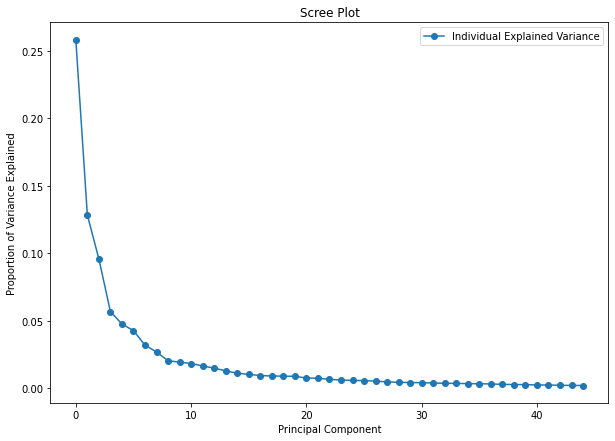

In [53]:
#scree plot of PCA
import matplotlib.pyplot as plt

explained_var_list = model.explainedVariance.toArray()

plt.figure(figsize=(10, 7))
plt.plot(explained_var_list, '-o', label="Individual Explained Variance")
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.legend()
plt.title('Scree Plot')
plt.show()

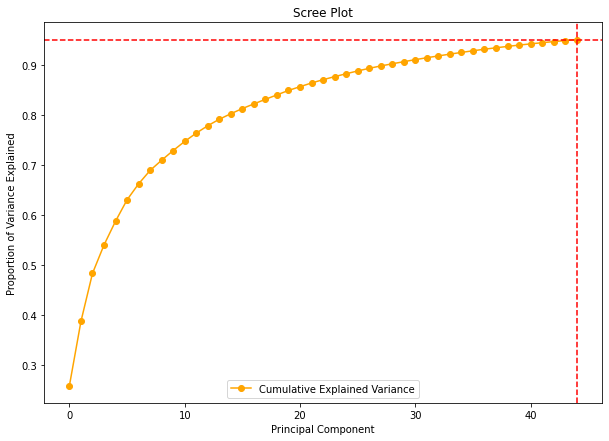

In [54]:
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(explained_var_list), '-o',c='orange', label="Cumulative Explained Variance")
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.axhline(0.95, linestyle='--', color='red')
plt.axvline(np.argmax(np.cumsum(explained_var_list) >= 0.95), linestyle='--', color='red')
plt.legend()
plt.title('Scree Plot')
plt.show()


In [55]:
from pyspark.sql.functions import stddev

# find columns with stdev = 0
constant_columns = [col_name for col_name, col_std in X_train_standard.agg(*[stddev(c).alias(c) for c in X_train_standard.columns]).collect()[0].asDict().items() if col_std == 0]

# delete these columns
X_train_standard = X_train_standard.drop(*constant_columns)

23/10/11 05:09:29 WARN TaskSetManager: Stage 17 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1241.7 KiB


In [56]:
Y_train

,00_01,00_02,00_03,01_02,01_03,02_03
Date,,,,,,
2017-01-03,-0.016833,-0.001611,-0.045658,0.015398,-0.028714,-0.044524
2017-01-04,-0.032378,-0.028563,0.024127,0.003990,0.057428,0.053640
2017-01-05,-0.037163,-0.053980,0.041080,-0.016765,0.079392,0.096795
2017-01-06,0.027781,0.034263,0.202046,0.006415,0.174882,0.169043
2017-01-09,-0.059976,-0.142651,-0.053769,-0.082919,0.007267,0.091636
...,...,...,...,...,...,...
2020-12-25,-0.028047,-0.111767,-0.127765,-0.083928,-0.099647,-0.014753
2020-12-28,-0.080718,-0.166078,-0.245042,-0.085346,-0.163635,-0.077583
2020-12-29,-0.088233,-0.194104,-0.302254,-0.105951,-0.213485,-0.106687


In [57]:
# feature seletion using correlation
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

var_filter = {}
for pair in ['00_01', '00_02', '00_03', '01_02', '01_03', '02_03']:
    
    target_df = spark.createDataFrame(Y_train[[pair]], ["label"])

#     # Print the first 5 rows of target_df for each pair
#     print(f"First 5 rows for pair {pair}:")
#     target_df.show(5)

    combined_df = X_train_standard.withColumn("id", F.monotonically_increasing_id()).join(target_df.withColumn("id", F.monotonically_increasing_id()), "id").drop("id")
    
    assembler = VectorAssembler(inputCols=X_train_standard.columns, outputCol="features")
    vector_df = assembler.transform(combined_df)
    
  
    corr_matrix = Correlation.corr(vector_df, "features").head()[0]
    last_col_index = corr_matrix.numCols - 1
    target_corr = [float(corr_matrix[i, last_col_index]) for i in range(corr_matrix.numRows - 1)]

    # Instead of top 50, let's try top 100 features
    top_feature_indices = sorted(range(len(target_corr)), key=lambda i: abs(target_corr[i]), reverse=True)[:50]
    
    selected_cols = [X_train_standard.columns[i] for i in top_feature_indices]
    
    var_filter[pair] = selected_cols

23/10/11 05:09:39 WARN TaskSetManager: Stage 20 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:42 WARN TaskSetManager: Stage 32 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:44 WARN TaskSetManager: Stage 44 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:47 WARN TaskSetManager: Stage 56 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:49 WARN TaskSetManager: Stage 68 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:09:51 WARN TaskSetManager: Stage 80 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.


In [58]:
import pandas as pd

var_filter_pandas = pd.DataFrame.from_dict(var_filter, orient='index').transpose()
var_filter_pandas.to_excel('var_filter.xlsx', index=False, engine='openpyxl')

In [59]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

n_estimators = 200
max_depth = 20

predictions = []
feature_importances_dict = {} 

X_train_spark = X_train_spark.withColumn("id", F.monotonically_increasing_id())
Y_train_spark = Y_train_spark.withColumn("id", F.monotonically_increasing_id())


for pair in ['00_01', '00_02', '00_03', '01_02', '01_03', '02_03']:
    assembler = VectorAssembler(inputCols=var_filter[pair], outputCol="features")
    
    rf = RandomForestRegressor(
        labelCol=pair,
        numTrees=n_estimators,
        maxDepth=max_depth,
        minInstancesPerNode=2,
        featureSubsetStrategy="all"
    )

    pipeline = Pipeline(stages=[assembler, rf])
    
    X_train_spark_Y = X_train_spark.join(Y_train_spark.select('id', pair), on='id', how='left').drop("id")

    model = pipeline.fit(X_train_spark_Y)

    feature_importances = model.stages[-1].featureImportances.toArray()
    feature_importances_dict[pair] = dict(zip(var_filter[pair], feature_importances))
    
    prediction = model.transform(X_test_spark)
    predictions.append(prediction.select("prediction"))

23/10/11 05:10:18 WARN TaskSetManager: Stage 92 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 05:10:27 WARN DAGScheduler: Broadcasting large task binary with size 1387.1 KiB
23/10/11 05:10:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/11 05:10:34 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/10/11 05:10:40 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/10/11 05:10:46 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/10/11 05:10:53 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
23/10/11 05:11:00 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
23/10/11 05:11:08 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/10/11 05:11:15 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
23/10/11 05:11:23 WARN DAGScheduler: Broadcasting large task binary with size 10.

23/10/11 05:20:06 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
23/10/11 05:20:16 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
23/10/11 05:20:27 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
23/10/11 05:20:37 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB
23/10/11 05:20:45 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
23/10/11 05:20:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/10/11 05:20:52 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/10/11 05:20:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/10/11 05:20:54 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/11 05:20:55 WARN DAGScheduler: Broadcasting large task binary with size 1452.9 KiB
23/10/11 05:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1512.4 KiB
23/10/11 05:20:57 WARN TaskSetManager: Stag

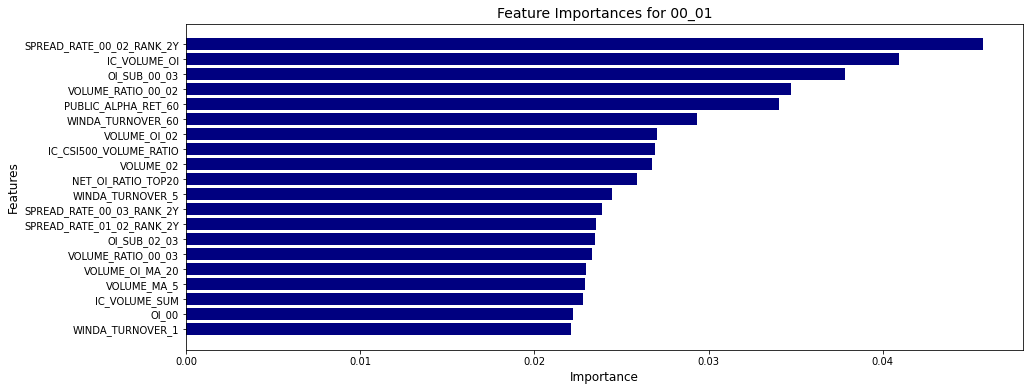

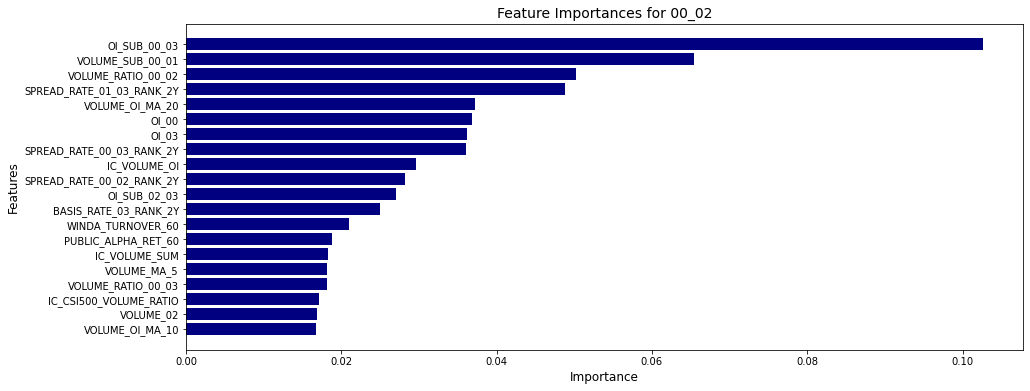

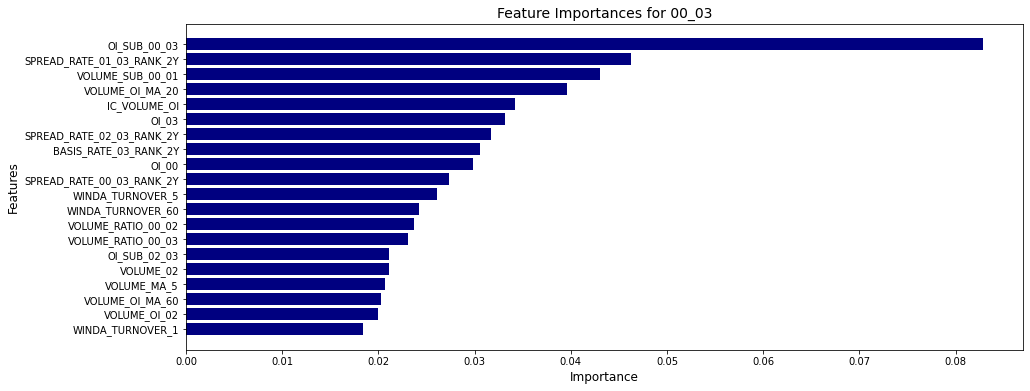

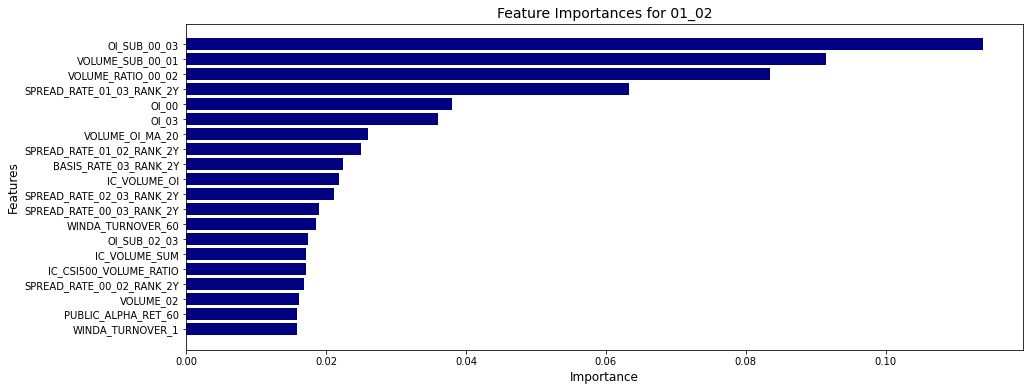

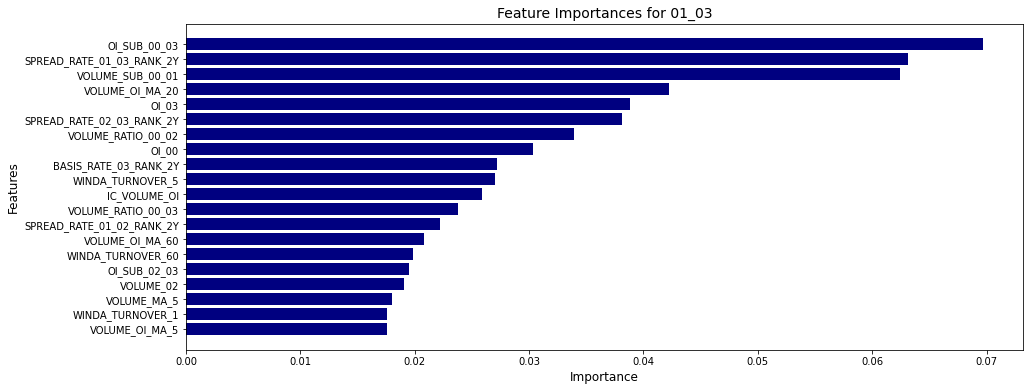

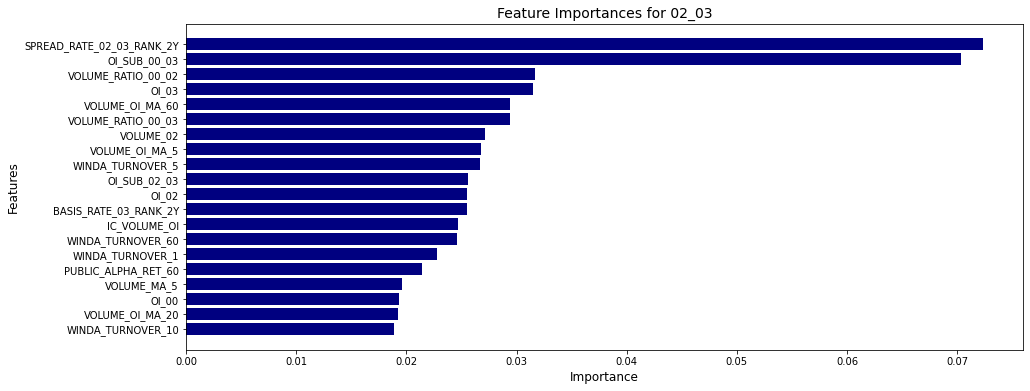

In [61]:
import matplotlib.pyplot as plt

for pair, importances in feature_importances_dict.items():
    # Sort features by importance in ascending order
    sorted_features = sorted(importances.items(), key=lambda x: x[1])
    
    # Extract feature names and their importance values
    features = [f[0] for f in sorted_features][-20:]  # Get the last 20 features
    values = [f[1] for f in sorted_features][-20:]  # Get the last 20 importance values
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.barh(features, values, align='center', color='navy')  # Use barh for horizontal bars, align to 'center', and set color to 'navy'
    plt.yticks(fontsize=10)  # Adjust font size using the fontsize parameter
    plt.ylabel('Features', fontsize=12)  # Increase fontsize for the y-label
    plt.xlabel('Importance', fontsize=12)  # Increase fontsize for the x-label
    plt.title(f'Feature Importances for {pair}', fontsize=14)  # Increase fontsize for the title
plt.show()



In [62]:
df_features = pd.DataFrame()

for pair, importances in feature_importances_dict.items():
    sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    features = [f[0] for f in sorted_features][:20]
    df_features[pair] = features

df_features.to_excel("important_features.xlsx", index=False)

In [63]:
Y_pred = pd.DataFrame()
for i in range(6):
    Y_pred = pd.concat([Y_pred,predictions[i].toPandas()], axis=1)
Y_pred.columns = ['00_01', '00_02', '00_03', '01_02', '01_03', '02_03']

In [64]:
Y_pred.index = Y_test.index

In [65]:
Y_pred

,00_01,00_02,00_03,01_02,01_03,02_03
Date,,,,,,
2021-01-04,-0.018126,-0.166060,-0.055863,-0.195789,-0.130167,-0.016574
2021-01-05,-0.018576,-0.020152,-0.018489,0.024381,0.016017,-0.005427
2021-01-06,-0.021449,-0.161750,-0.054901,-0.182327,-0.094134,-0.015559
2021-01-07,0.011167,-0.112282,0.050384,-0.184299,-0.009621,0.041064
2021-01-08,0.011751,-0.133294,-0.039434,-0.203135,-0.089452,0.000637
...,...,...,...,...,...,...
2023-06-14,0.006971,-0.097068,0.024973,-0.122615,-0.061797,0.073088
2023-06-15,0.005482,-0.096473,0.031178,-0.118195,-0.048107,0.075292
2023-06-19,-0.001602,-0.070519,0.016991,-0.120502,-0.063393,0.030947


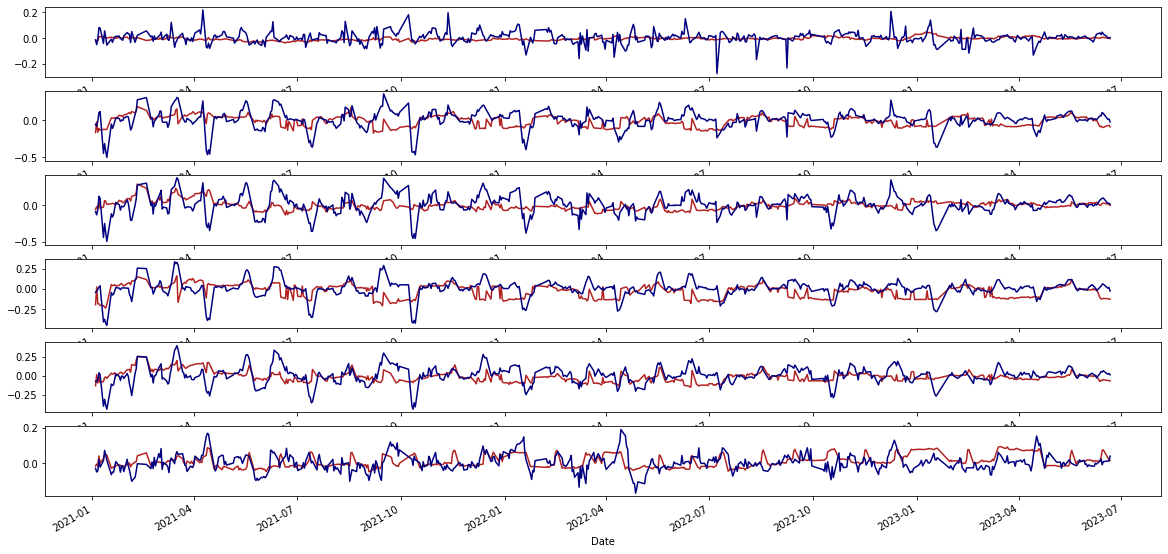

In [66]:
#plot prediction and true value
plt.figure(figsize = (20,10))
count = 1
for item in Y_test.columns:
    plt.subplot(6,1,count)
    pred_temp = Y_pred[item]
    Y_test_temp = Y_test[item]
    pred_temp.plot(c = 'firebrick')
    Y_test_temp.plot(c = 'navy')
    count += 1

In [67]:
#calculate mse
from sklearn import metrics
mse = pd.Series()
for item in Y_test.columns:
    mse[item] = metrics.mean_squared_error(Y_test[item], Y_pred[item])
mse

00_01    0.002400
00_02    0.016747
00_03    0.018459
01_02    0.014582
01_03    0.014884
02_03    0.002484
dtype: float64

In [68]:
#calculate accuracy rate
accuracy = (Y_test.idxmax(axis=1) == Y_pred.idxmax(axis=1))
accuracy_rate = accuracy.sum()/len(accuracy)
accuracy_rate

0.2147887323943662

In [69]:
#redefine success rate and calculate
success = 0
for date in Y_test.index:
    if Y_test.loc[date,Y_pred.idxmax(axis=1).loc[date]] > Y_test.loc[date,:].median():
        success += 1
success_rate = success/len(Y_test)
success_rate

0.5845070422535211

In [70]:
def performance_stat(value_data):
    daily_return = value_data.pct_change()
    cum_return = value_data[-1]/value_data[0] - 1
    annualized_return = cum_return * 50 / len(value_data)  #Simple interest
#     annualized_return = np.power(cum_return + 1, 250 / len(value_data)) - 1 # compound
    annualized_vol = daily_return.std() * np.sqrt(50)
    sharpe = (annualized_return - 0) / annualized_vol
    # maximum drawdown
    MaxDD = 0
    try:
        for i in np.arange(1,len(value_data)):
            MaxDD = min(MaxDD, value_data[i]/max(value_data[:i+1]) - 1 )
    except:
        MaxDD = None
    
    calmar = (annualized_return - 0) / abs(MaxDD)
    
    return pd.DataFrame([cum_return,annualized_return,annualized_vol,MaxDD,sharpe,calmar],
                       index = ['Cumulative return','Annual return','Annual vol','MaxDrawDown','Sharpe','Calmar'],
                       columns = ['Summary'])

<AxesSubplot:>

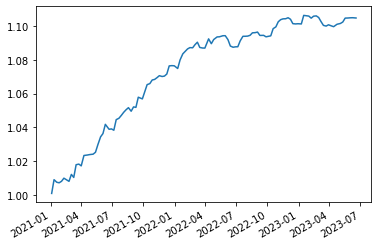

In [71]:
# RF calculating backtestinbg curve
max_pair = Y_pred.abs().idxmax(axis=1)
date_list = []
ret_list = []
for i,date in enumerate(Y_test.index):
    if i%5 == 0:
        date_list.append(date)
        if Y_pred.loc[date,max_pair.loc[date]]>0:
            ret_list.append(Y_test.loc[date,max_pair.loc[date]]/50)
        if Y_pred.loc[date,max_pair.loc[date]]<0:
            ret_list.append(-Y_test.loc[date,max_pair.loc[date]]/50)
backtest = pd.DataFrame(index = date_list)
backtest['return'] = ret_list
backtest['value'] = 1 + np.cumsum(backtest['return']) 
backtest.value.plot()  

In [97]:
performance_stat(backtest.value)

,Summary
Cumulative return,0.101985
Annual return,0.044730
Annual vol,0.016183
MaxDrawDown,-0.006362
Sharpe,2.763967
Calmar,7.030710


In [72]:
# Neural Network model
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(solver='adam', random_state=1, 
                  hidden_layer_sizes=(100, 100), activation='relu', 
                  alpha=1e-5, max_iter=1000)


Y_pred = pd.DataFrame(columns = Y.columns)
for pair in ['00_01','00_02','00_03','01_02','01_03','02_03']:
    nn.fit(X_train_standard.toPandas()[var_filter[pair]],Y_train[pair])
    pred = nn.predict(X_test_standard.toPandas()[var_filter[pair]])
    Y_pred.loc[:,pair] = pred

23/10/11 03:23:40 WARN TaskSetManager: Stage 629 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 03:23:45 WARN TaskSetManager: Stage 631 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 03:23:51 WARN TaskSetManager: Stage 633 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 03:23:57 WARN TaskSetManager: Stage 635 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 03:24:02 WARN TaskSetManager: Stage 637 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.
23/10/11 03:24:08 WARN TaskSetManager: Stage 639 contains a task of very large size (1270 KiB). The maximum recommended task size is 1000 KiB.


In [73]:
Y_pred.index = Y_test.index

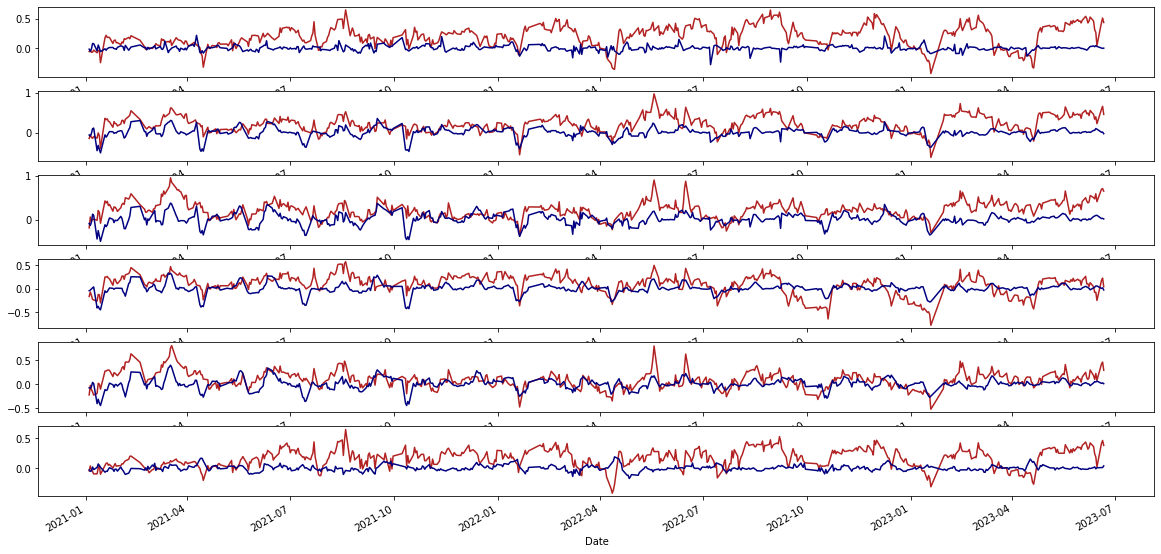

In [74]:
#plot prediction and true value
plt.figure(figsize = (20,10))
count = 1
for item in Y_test.columns:
    plt.subplot(6,1,count)
    pred_temp = Y_pred[item]
    Y_test_temp = Y_test[item]
    pred_temp.plot(c = 'firebrick')
    Y_test_temp.plot(c = 'navy')
    count += 1

In [75]:
#calculate mse
from sklearn import metrics
mse = pd.Series()
for item in Y_test.columns:
    mse[item] = metrics.mean_squared_error(Y_test[item], Y_pred[item])
mse

00_01    0.076360
00_02    0.084194
00_03    0.081832
01_02    0.046478
01_03    0.036703
02_03    0.055036
dtype: float64

In [76]:
#calculate accuracy rate
accuracy = (Y_test.idxmax(axis=1) == Y_pred.idxmax(axis=1))
accuracy_rate = accuracy.sum()/len(accuracy)
accuracy_rate

0.2482394366197183

In [77]:
#redefine success rate and calculate
success = 0
for date in Y_test.index:
    if Y_test.loc[date,Y_pred.idxmax(axis=1).loc[date]] > Y_test.loc[date,:].median():
        success += 1
success_rate = success/len(Y_test)
success_rate

0.5545774647887324

<AxesSubplot:>

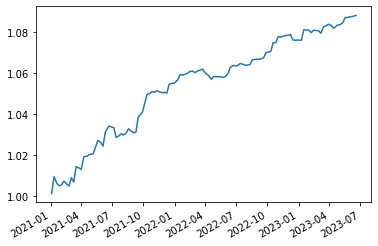

In [78]:
# NN calculating backtestinbg curve
max_pair = Y_pred.abs().idxmax(axis=1)
date_list = []
ret_list = []
for i,date in enumerate(Y_test.index):
    if i%5 == 0:
        date_list.append(date)
        if Y_pred.loc[date,max_pair.loc[date]]>0:
            ret_list.append(Y_test.loc[date,max_pair.loc[date]]/50)
        if Y_pred.loc[date,max_pair.loc[date]]<0:
            ret_list.append(-Y_test.loc[date,max_pair.loc[date]]/50)
backtest = pd.DataFrame(index = date_list)
backtest['return'] = ret_list
backtest['value'] = 1 + np.cumsum(backtest['return']) 
backtest.value.plot()  



In [106]:
performance_stat(backtest.value)

,Summary
Cumulative return,0.086512
Annual return,0.037944
Annual vol,0.015210
MaxDrawDown,-0.005457
Sharpe,2.494667
Calmar,6.952608
